In [48]:
import matplotlib.pyplot as plt
import json, pandas as pd, glob, tqdm

tables = {}
for f in tqdm.tqdm(glob.glob('saved/*/log.jsons')):
    args, hparams = {}, {}
    with open(f) as fh:
        for l in fh:
            j = json.loads(l)
            t = j.pop('table')
            if t == 'args': args = j
            elif t == 'hyperparams': hparams = j
            elif t == 'epoch':
                j.update(args)
                j.update(hparams)
                tables.setdefault(t, []).append(j)
dfs = {t: pd.DataFrame(v) for t, v in tables.items()}
epoch = dfs['epoch']


epoch['plotdim'] = epoch.apply(lambda x:
                               6 if x.netspec == 'inf' else x['ndim'], 1)

final = epoch[(epoch.i == 29) & (epoch.dt == 0.5)]
final = final[final.tgtfreq == 10]

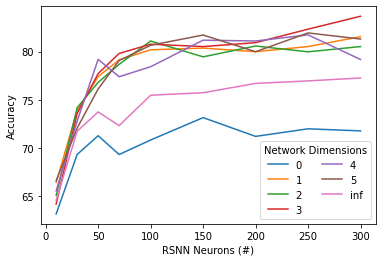

In [51]:
take = [
    '3e0.00', '3e0.05', '3e0.10', '3e0.15',
    '3e0.20', '3e0.25', '3e0.30', '3e0.35',
    '3e0.40', '3e0.45', '3e0.50']

finalnormal = final[~final.net.isin(take)]

finalnormal

for net, sub in finalnormal.groupby('netspec'):
    sub = sub.sort_values('nhidden') # type: ignore
    sub = sub[['nhidden', 't1p']].groupby('nhidden').median()
    plt.plot(sub.index, sub.t1p, label=net)
plt.legend(title='Network Dimensions', ncol=2)
plt.xlabel('RSNN Neurons (#)')
plt.ylabel('Accuracy')
plt.show()


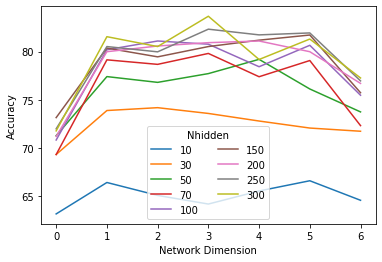

In [52]:
for nh, sub in finalnormal.groupby('nhidden'):
    sub = sub.sort_values('plotdim') # type: ignore
    sub = sub[['plotdim', 't1p']].groupby('plotdim').median()
    plt.plot(sub.index, sub.t1p, label=nh)
plt.legend(title='Nhidden', ncol=2)
plt.xlabel('Network Dimension')
plt.ylabel('Accuracy')
plt.show()

In [39]:
take = [
    '3e0.00', '3e0.05', '3e0.10', '3e0.15',
    '3e0.20', '3e0.25', '3e0.30', '3e0.35',
    '3e0.40', '3e0.45', '3e0.50']

finaleps = final[final.net.isin(take)]

finaleps = (finaleps.loc[:, finaleps.nunique() > 1]).copy()
finaleps['eps'] = finaleps['netspec'].str.split('e').str[1].astype(float)
print(finaleps['netspec'].values[0])
finaleps = finaleps.drop('netspec', axis='columns').drop('net', axis='columns').drop('id', axis='columns')
finaleps = finaleps.groupby(['nhidden', 'eps']).median().reset_index().drop('seed', axis='columns')
finaleps

3e0.30


,nhidden,eps,t1p,t3p,t1p_train,t3p_train
0,10,0.00,66.247108,89.076973,79.890324,95.853367
1,10,0.05,64.959496,88.418697,79.349461,95.560394
2,10,0.10,65.480324,87.912327,81.234974,95.582932
3,10,0.15,65.834778,88.628471,79.139122,95.710636
4,10,0.20,65.205437,87.659145,80.280949,95.462742
5,10,0.25,65.726276,88.078709,78.756008,94.568810
6,10,0.30,63.360823,87.557869,79.725060,95.462738
7,10,0.35,64.894386,88.382526,79.356972,95.492790
8,10,0.40,63.982929,89.286747,82.406849,96.319111
9,10,0.45,67.440685,90.241608,79.552280,95.289963


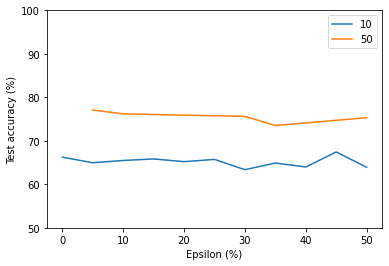

In [47]:
for n, sub in finaleps.groupby('nhidden'):
    if n not in [10, 50]:
        continue
    plt.plot(sub.eps * 100, sub.t1p, label=n)
    # plt.plot(sub.eps * 100, sub.t1p_train, label=n)

plt.xlabel('Epsilon (%)')
plt.ylabel('Test accuracy (%)')
plt.ylim(50, 100)
plt.savefig('./')
plt.legend()

In [54]:
# 

In [55]:
# 

In [56]:
# 

In [61]:
glob.glob('saved/*/epoch_00000000.npz')

['saved/20251104_d3e0.20_h30_lr0.001_llNone_dt0.5_afc5c244-596f-420f-879e-309365f52e6f/epoch_00000000.npz',
 'saved/20251104_d3e0.30_h30_lr0.001_llNone_dt0.5_e8bd082a-a831-4e71-80b0-c6098f704447/epoch_00000000.npz',
 'saved/20251104_d3e0.05_h30_lr0.001_llNone_dt0.5_963e1b63-2a46-4fb9-ac70-c99e6b74c4d2/epoch_00000000.npz',
 'saved/20251104_d3e0.35_h50_lr0.001_llNone_dt0.5_39fedb01-1252-4754-8d9c-cb8d107443d5/epoch_00000000.npz',
 'saved/20251104_d3e0.15_h30_lr0.001_llNone_dt0.5_7fbc0dae-73a9-4cb7-9ce0-abdde7a84c84/epoch_00000000.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_57d1a776-849d-4705-90c3-b8a7acaf3804/epoch_00000000.npz',
 'saved/20251104_d3e0.30_h30_lr0.001_llNone_dt0.5_13be9b44-6194-4043-81b0-62432b37a376/epoch_00000000.npz',
 'saved/20251104_d3e0.40_h10_lr0.001_llNone_dt0.5_6a790a35-ad0e-430d-a16f-d5bf7ebb2620/epoch_00000000.npz',
 'saved/20251104_d3e0.45_h10_lr0.001_llNone_dt0.5_a87e8c53-630b-48c7-91a7-99daf31af989/epoch_00000000.npz',
 'saved/20251104_d3e0.35_h10

In [63]:
#'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_d57726df-ed90-4fa3-a28a-f9d6c8288b4c/epoch_00000000.npz'
sorted(x for x in glob.glob(
    'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_*.npz'
) if not 'read' in x)


['saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000000.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000001.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000002.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000003.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000004.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000005.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000006.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000007.npz',
 'saved/20251104_d3e0.00_h30_lr0.001_llNone_dt0.5_937dcdb4-e2f0-4c7b-8384-9257ad4c7987/epoch_00000008.npz',
 'saved/20251104_d3e0.00_h30